# HW1 : Regression, Cross-Validation, and  Regularization

In [1]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [2]:
from matplotlib import pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

In [3]:
SEED = 12345 

DATA_DIR = 'data_auto'

### Methods for loading dataset

In [4]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [5]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [6]:
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [7]:
print(x_tr_MF[:5])

[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [8]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

In [9]:
print(y_tr_M[:5,np.newaxis])

[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [10]:
y_tr_M.max()

46.6

In [11]:
Y_MAX = 60.0

## Load completed code

In [12]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

## Define useful plotting functions

In [13]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [14]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

In [15]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])

In [16]:
bad_yhat_N

array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [17]:
sanitize(bad_yhat_N)

array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

Code for Problem 1

In [18]:
def make_pipeline__unpenalized_linear_regr_with_poly_feats(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

Code for Problem 2

In [19]:
def make_pipeline__ridge_linear_regr_with_poly_feats(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

In [20]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Problem 0: Simple Baseline: Guess-the-Training-Set-Mean

It is a good engineering practice to try simple approaches before complex models.

Here's a very simple regression model: given a training set, compute its mean and store that as $\bar{y}$.

Then, define the prediction function of this model as

$$
\hat{y}( x_* ) = \bar{y}
$$

That is, no matter what feature vector $x_*$ is provided, always guess the train-set-mean $\bar{y}$.

### Implementation Step 0A

Determine the mean y-value of the train set, using arrays `x_tr_MF` and `y_tr_M`.

In [21]:
y_mean = np.mean(y_tr_M)
ybar = np.full(len(y_tr_M), y_mean)

### Implementation Step 0B

Compute the RMSE this baseline gets on the train set, val set, and test set


In [22]:
baseline_err_tr = calc_root_mean_squared_error(y_tr_M, ybar) # TODO fixme
baseline_err_va = calc_root_mean_squared_error(y_va_N, np.full(len(y_va_N), np.mean(y_va_N))) # TODO fixme
baseline_err_te = calc_root_mean_squared_error(y_te_P, np.full(len(y_te_P), np.mean(y_te_P))) # TODO fixme

# Problem 1: Polynomial Degree Selection on Fixed Validation Set


### Implementation Step 1A
    
Fit a linear regression model to a polynomial feature transform when degree = 1



In [23]:
# TODO create a pipeline using features with current degree value
model_1 = make_pipeline__unpenalized_linear_regr_with_poly_feats(1)
# TODO fit this pipeline on provided training data
model_1.fit(x_tr_MF, y_tr_M)

Pipeline(steps=[('rescaler', MinMaxScaler()),
                ('poly_transformer',
                 PolynomialFeatures(degree=1, include_bias=False)),
                ('linear_regr', LinearRegression())])

### Short Answer 1a

Provide the weight coefficient values (to 2 decimal places) for your degree = 1 model

In [24]:
# Hint: The names of the original F=4 features are already in your workspace
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [25]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
# Copy these results neatly into your report
pretty_print_learned_weights(model_1,xcolnames_F)

 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


### Short Answer 1b

What monotonic relationship does this degree=1 linear model imply about:

* case 1: how engine *weight* impacts efficiency (in mpg)
* case 2: how *displacement* impacts efficiency (in mpg)

Does the model's implied direction of these relationships agree with your common sense? With this dataset? Why or why not?

*Hint*: Recall that [engine displacement](https://en.wikipedia.org/wiki/Engine_displacement) refers to the overall volume of air that can move through the engine. Larger engine means larger displacement.

In [26]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1B

Fit models with degree 2 and 4. 

Inspect the overall *number* of learned weights, as well as the values of the weights.

In [27]:
for degree in [2]:
    print(f"degree={degree}")
    # TODO create a pipeline using features with current degree value
    model = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree)

    model.fit(x_tr_MF, y_tr_M)
    # TODO fit this pipeline on provided training data
    pretty_print_learned_weights(model,xcolnames_F)
    # TODO call pretty_print_learned_weights


degree=2
 -40.72 : x0
  -7.20 : x1
 -11.00 : x2
 -11.10 : x3
  -4.45 : x0^2
   8.80 : x0 x1
  26.38 : x0 x2
   8.98 : x0 x3
 -31.77 : x1^2
  27.17 : x1 x2
  13.43 : x1 x3
  21.76 : x2^2
 -80.86 : x2 x3
  52.65 : x3^2
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


In [28]:
for degree in [4]:
    print(f"degree={degree}")
    # TODO create a pipeline using features with current degree value
    model = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree)

    model.fit(x_tr_MF, y_tr_M)
    # TODO fit this pipeline on provided training data
    pretty_print_learned_weights(model,xcolnames_F)
    # TODO call pretty_print_learned_weights

degree=4
 617.45 : x0
-191.08 : x1
 1774.24 : x2
-1343.56 : x3
 159.25 : x0^2
-323.66 : x0 x1
-5179.64 : x0 x2
 198.45 : x0 x3
  61.37 : x1^2
 2573.25 : x1 x2
-1596.95 : x1 x3
-5943.40 : x2^2
 7359.52 : x2 x3
 2883.15 : x3^2
-630.58 : x0^3
 1377.51 : x0^2 x1
-1600.47 : x0^2 x2
 1529.25 : x0^2 x3
-105.12 : x0 x1^2
-7880.76 : x0 x1 x2
 12085.95 : x0 x1 x3
 13051.50 : x0 x2^2
 5626.91 : x0 x2 x3
-14222.70 : x0 x3^2
 611.22 : x1^3
-1478.94 : x1^2 x2
-359.76 : x1^2 x3
-7343.55 : x1 x2^2
 17674.97 : x1 x2 x3
-13648.53 : x1 x3^2
 4525.05 : x2^3
  47.94 : x2^2 x3
-34068.88 : x2 x3^2
 20804.11 : x3^3
-345.94 : x0^4
 1047.47 : x0^3 x1
 133.89 : x0^3 x2
 702.32 : x0^3 x3
 1031.68 : x0^2 x1^2
 3678.25 : x0^2 x1 x2
-11633.91 : x0^2 x1 x3
-1147.94 : x0^2 x2^2
 1506.00 : x0^2 x2 x3
 3042.21 : x0^2 x3^2
-5637.55 : x0 x1^3
 3990.55 : x0 x1^2 x2
 7624.03 : x0 x1^2 x3
 12467.48 : x0 x1 x2^2
-36650.46 : x0 x1 x2 x3
 19120.42 : x0 x1 x3^2
-6959.36 : x0 x2^3
-12414.29 : x0 x2^2 x3
 31670.59 : x0 x2 x3^2
-15

### Short Answer 1c

What do you notice about the weight values for degree 4 compared to the values with degree 1 or 2?


In [29]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1C

We'll now perform a "complete" experiment for our `fv` (fixed validation set) pipeline with unpenalized linear regression.

We want to try all possible degrees in [1, 2, 3, 4, 5, 6, 7]

For each one, we'll build a fresh pipeline, fit the model of specified degree, and record the *train* error and the *validation* error.

In [30]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    model = make_pipeline__unpenalized_linear_regr_with_poly_feats(degree)
    model.fit(x_tr_MF, y_tr_M)
    # Compute training error
    yhat_tr_M = sanitize(model.predict(x_tr_MF))  # TODO fixme, be sure to sanitize predictions
    yhat_va_N = sanitize(model.predict(x_va_NF))  # TODO fixme, be sure to sanitize predictions

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)# TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    # TODO store current pipeline for future use
    fv_pipeline_list.append(model)

### Figure 1: Error vs degree

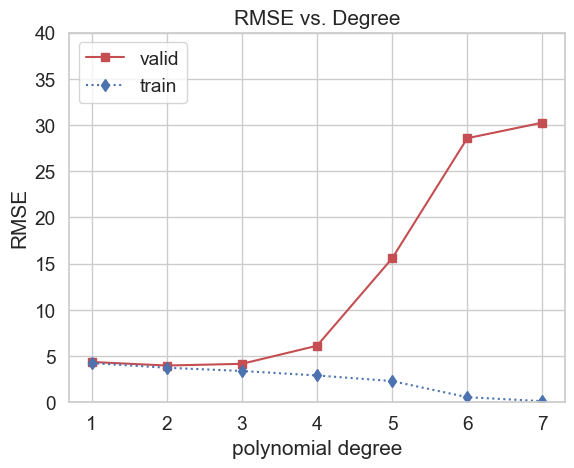

In [31]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

### Short Answer 1d

For this provided training set, what do you notice happens to training error between degree 6 and degree 7. Does this agree with the conceptual understanding from day03 about how training error behaves as a function of $N$ and number of regression features $F$?

In [32]:
# WRITE ANSWER IN YOUR REPORT!

### Implementation 1D: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [33]:
min_val_error = min(fv_err_va_list)
sele_degree = fv_err_va_list.index(min_val_error)+1
best_para1 = dict(degree=sele_degree, alpha="NA")
print("Selected Parameters: ")
print(sele_degree)
print("Fixed validation set estimate of heldout error:")
print(min_val_error)
y_pred_te =  sanitize(fv_pipeline_list[sele_degree-1].predict(x_te_PF))
test_error = calc_root_mean_squared_error(y_te_P, y_pred_te)
print("Error on the test-set:")
print(test_error)

Selected Parameters: 
2
Fixed validation set estimate of heldout error:
3.974075330754534
Error on the test-set:
3.9915025464567595


In [34]:
# TODO store score on test set for later

model1_err_tr = fv_err_tr_list[sele_degree-1] # TODO fixme
model1_err_va = min_val_error # TODO fixme
model1_err_te = test_error # TODO fixme

### Implementation 1E

We'll now try to repeat the above *without* the MinMaxScalar preprocessing step. 

Part 1:

* Make a copy of make_pipeline__unpenalized_linear_regr_with_poly_feats, call it make_pipeline__bad
* Edit the function so it does not perform MinMaxScalar, but does everything else as before.

Part 2:

* Fit a pipeline without preprocessing at each degree value [1, 2, ... 7]
* Record the train error at each degree value




Selected Parameters: 
2
Fixed validation set estimate of heldout error:
3.974075330762354
Error on the test-set:
3.991502546447113


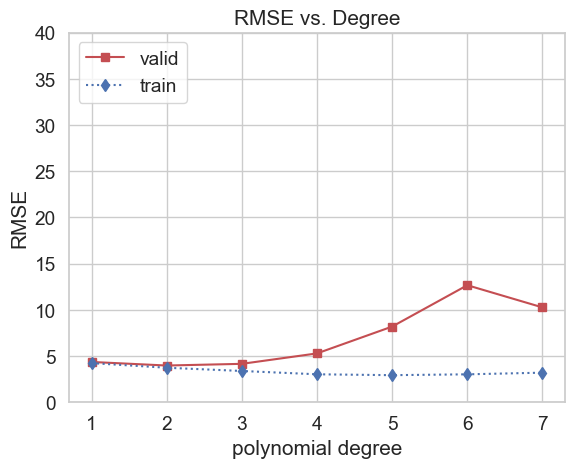

In [35]:
def make_pipeline__unpenalized_linear_regr_with_poly_feats_parte(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    model = make_pipeline__unpenalized_linear_regr_with_poly_feats_parte(degree)
    model.fit(x_tr_MF, y_tr_M)
    # Compute training error
    yhat_tr_M = sanitize(model.predict(x_tr_MF))  # TODO fixme, be sure to sanitize predictions
    yhat_va_N = sanitize(model.predict(x_va_NF))  # TODO fixme, be sure to sanitize predictions

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N)# TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)
    
    # TODO store current pipeline for future use
    fv_pipeline_list.append(model)
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree')
min_val_error = min(fv_err_va_list)
sele_degree = fv_err_va_list.index(min_val_error)+1
print("Selected Parameters: ")
print(sele_degree)
print("Fixed validation set estimate of heldout error:")
print(min_val_error)
y_pred_te =  sanitize(fv_pipeline_list[sele_degree-1].predict(x_te_PF))
test_error = calc_root_mean_squared_error(y_te_P, y_pred_te)
print("Error on the test-set:")
print(test_error)


### Short Answer 1e

What happens to train error as a function of degree when the MinMaxScalar preprocessing step is omitted? Can we make sense of this trend using the concept of overfitting, or is there some other explanation? For a LR model with polynomial features and degree above 2, why is it useful to rescale each feature column to be in the interval 0 to 1?


In [36]:
# WRITE ANSWER IN YOUR REPORT!


# Problem 2: Alpha Selection on Fixed Val Set

In [37]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


### Implementation 2A

In [38]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    model = make_pipeline__ridge_linear_regr_with_poly_feats(4, alpha)
    model.fit(x_tr_MF,y_tr_M)
    yhat_tr_M = sanitize(model.predict(x_tr_MF)) # TODO fixme, be sure to call predict and then sanitize
    yhat_va_N = sanitize(model.predict(x_va_NF)) # TODO fixme, be sure to call predict and then sanitize
    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)
    fv2_pipeline_list.append(model)
    # TODO store current pipeline for future use

### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

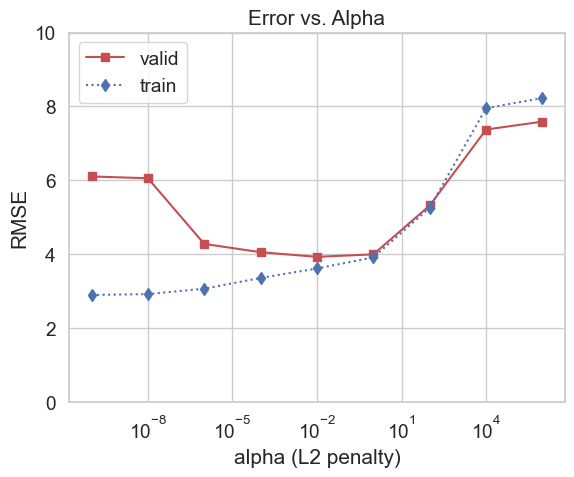

In [39]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [40]:
min_val_error = min(fv2_err_va_list)
sele_index = fv2_err_va_list.index(min_val_error)
best_para = alpha_list[sele_index]
best_para2 = dict(degree=4, alpha=best_para)
print("Selected Parameters: ")
print(alpha_list[sele_index])
print("Fixed validation set estimate of heldout error:")
print(min_val_error)
y_pred_te =  sanitize(fv2_pipeline_list[sele_index].predict(x_te_PF))
test_error = calc_root_mean_squared_error(y_te_P, y_pred_te)
print("Error on the test-set:")
print(test_error)

Selected Parameters: 
0.01
Fixed validation set estimate of heldout error:
3.9313878334812533
Error on the test-set:
3.877667860403783


In [41]:
# TODO store errors on test set for later

model2_err_tr = fv2_err_tr_list[sele_index] # TODO fixme
model2_err_va = min_val_error # TODO fixme
model2_err_te = test_error # TODO fixme

### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.

What do you notice about the relative magnitudes compared to the degree-4 model from Problem 1?

In [42]:
for degree in [4]:
    print(f"degree={degree}")

    pretty_print_learned_weights(fv2_pipeline_list[sele_index] ,xcolnames_F)


degree=4
 -39.88 : x0
   1.56 : x1
  14.71 : x2
 -13.32 : x3
  -6.53 : x0^2
  -5.93 : x0 x1
  21.96 : x0 x2
  24.36 : x0 x3
 -22.82 : x1^2
   2.39 : x1 x2
  -2.18 : x1 x3
 -19.42 : x2^2
 -26.81 : x2 x3
   3.47 : x3^2
   9.93 : x0^3
   5.41 : x0^2 x1
   9.37 : x0^2 x2
  14.07 : x0^2 x3
   8.22 : x0 x1^2
   7.41 : x0 x1 x2
  12.85 : x0 x1 x3
   0.12 : x0 x2^2
  -1.49 : x0 x2 x3
   0.97 : x0 x3^2
  -5.93 : x1^3
  -2.12 : x1^2 x2
  -2.79 : x1^2 x3
   0.19 : x1 x2^2
  -2.80 : x1 x2 x3
  -0.49 : x1 x3^2
  -4.76 : x2^3
  -3.17 : x2^2 x3
   3.10 : x2 x3^2
   5.33 : x3^3
   5.15 : x0^4
  -4.71 : x0^3 x1
  -1.87 : x0^3 x2
   5.64 : x0^3 x3
  -2.97 : x0^2 x1^2
  -5.04 : x0^2 x1 x2
   1.79 : x0^2 x1 x3
 -10.96 : x0^2 x2^2
  -4.93 : x0^2 x2 x3
  -3.79 : x0^2 x3^2
   4.44 : x0 x1^3
   2.40 : x0 x1^2 x2
   5.23 : x0 x1^2 x3
  -4.37 : x0 x1 x2^2
  -0.25 : x0 x1 x2 x3
  -1.68 : x0 x1 x3^2
 -16.61 : x0 x2^3
 -11.02 : x0 x2^2 x3
 -10.19 : x0 x2 x3^2
 -13.04 : x0 x3^3
   2.39 : x1^4
   3.05 : x1^3 x2
   0

### Short Answer 2b

*See instructions on website*



For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total. We can use all 292 examples to develop models.

In [43]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter configuration (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [44]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
for param in ridge_param_list:
    # TODO make pipeline
    model = make_pipeline__ridge_linear_regr_with_poly_feats(param["degree"],param["alpha"])
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(model, x_trva_LF, y_trva_L,K, SEED) # TODO

    err_tr = np.mean(tr_error_K) # TODO fixme, compute average error across all train folds
    err_va = np.mean(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

In [45]:
min_error = min(cv_valid_err_list)
sele_index = cv_valid_err_list.index(min_error)
param = ridge_param_list[sele_index]
model = make_pipeline__ridge_linear_regr_with_poly_feats(param["degree"],param["alpha"])
model.fit(x_trva_LF,y_trva_L)
y_pred_te = model.predict(x_te_PF)
error =  calc_root_mean_squared_error(y_pred_te,y_te_P)

In [46]:
print("Selected Parameters:")
print(param)
print("10-fold CV estimate of heldout error:")
print(min_error)
print("Error on the test-set:")
print(error)

Selected Parameters:
{'degree': 7, 'alpha': 0.1}
10-fold CV estimate of heldout error:
3.8599472
Error on the test-set:
3.8168267610803133


In [47]:
# TODO store score on test set for later

model3_err_tr = calc_root_mean_squared_error(model.predict(x_tr_MF) ,y_tr_M) # TODO fixme
model3_err_va = calc_root_mean_squared_error(model.predict(x_va_NF) ,y_va_N) # TODO fixme
model3_err_te = error # TODO fixme

## Table 3 : Comparing pipelines on test set

In [48]:
result_row_list = []
result_row_list.append(
    dict(
    name='predict mean of train ys',
    hypers='',
    testRMSE=baseline_err_te,
    ))
result_row_list.append(
    dict(
    name='LR deg=best-on-val',
    hypers=str(best_para1),
    testRMSE=model1_err_te,
    ))
result_row_list.append(
    dict(
    name='ridgeLR deg=4 alph=best-on-val',
    hypers=str(best_para2),
    testRMSE=model2_err_te,
    ))
result_row_list.append(
    dict(
    name='ridgeLR deg=best-on-CV alph=best-on-CV',
    hypers=str(param),
    testRMSE=model3_err_te,
    ))



In [49]:
pd.set_option('display.precision', 3)
result_df = pd.DataFrame(result_row_list)
result_df

,name,hypers,testRMSE
0,predict mean of train ys,,7.062
1,LR deg=best-on-val,"{'degree': 2, 'alpha': 'NA'}",3.992
2,ridgeLR deg=4 alph=best-on-val,"{'degree': 4, 'alpha': 0.01}",3.878
3,ridgeLR deg=best-on-CV alph=best-on-CV,"{'degree': 7, 'alpha': 0.1}",3.817
